# Useful Imports

In [8]:
from KernelFlow import KernelFlowsCNNGP
from torchvision import datasets, transforms
import torch
import torch.nn.functional as F
import numpy as np
from utils import get_accuracy
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision.transforms as T
from torch import nn
import time
from cnn_gp import Sequential, Conv2d, ReLU, resnet_block
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Global parameters

In [3]:
N_I = 200

# Dataset

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                T.Lambda(lambda x: torch.flatten(x)),
                                T.Lambda(lambda x: nn.functional.normalize(x, p=2, dim=0)),
                                T.Lambda(lambda x: torch.reshape(x, (28,28))),
                                T.Lambda(lambda x: torch.unsqueeze(x, dim=0))
                              ])

batch_size = 10000
val_size = 100

# MNIST
trainset = datasets.MNIST('MNIST_dataset/train', download=True, train=True, transform=transform)
valset = datasets.MNIST('MNIST_dataset/val', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=val_size, shuffle=False)

# Fashion MNIST
# trainset = datasets.FashionMNIST('Fashion_MNIST_dataset/train', download=True, train=True, transform=transform)
# valset = datasets.FashionMNIST('Fashion_MNIST_dataset/val', download=True, train=False, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
# valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataiter = iter(trainloader)
X_train, Y_train = dataiter.next()
# X_train = nn.functional.normalize(X_train, p=2)
Y_train = F.one_hot(Y_train, 10)

dataiter_val = iter(valloader)
X_test, Y_test = dataiter_val.next()


In [5]:
print(X_train[0].shape, torch.norm(X_train[0])) 

torch.Size([1, 28, 28]) tensor(1.)


# Model

In [6]:
model_untrained = Sequential(
        Conv2d(kernel_size=3),
        ReLU(),
        Conv2d(kernel_size=3, stride=2),
        ReLU(),
        Conv2d(kernel_size=14, padding=0),  # equivalent to a dense layer
        )

# Pretraining Results

In [7]:
Y_pred_untrained = KernelFlowsCNNGP.kernel_regression(X_test=X_test, X_train = X_train[:500], Y_train = Y_train[:500].to(torch.float32), kernel = model_untrained)
Y_pred_untrained = torch.argmax(Y_pred_untrained, axis=1)
accuracy_untrained = get_accuracy(Y_pred_untrained.detach().numpy(), Y_test.detach().numpy())
print("The accuracy with training was: ", accuracy_untrained)

The accuracy with training was:  80.0


In [9]:
N_i_arr = np.arange(50, 400, 50)
untrained_accuracy_list = []

for ni in tqdm(N_i_arr):
    Y_pred_untrained = KernelFlowsCNNGP.kernel_regression(X_test=X_test, X_train = X_train[:ni], Y_train = Y_train[:ni].to(torch.float32), kernel = model_untrained)
    Y_pred_untrained = torch.argmax(Y_pred_untrained, axis=1)
    untrained_accuracy_list.append(get_accuracy(Y_pred_untrained.detach().numpy(), Y_test.detach().numpy()))

100%|██████████| 7/7 [01:08<00:00,  9.80s/it]


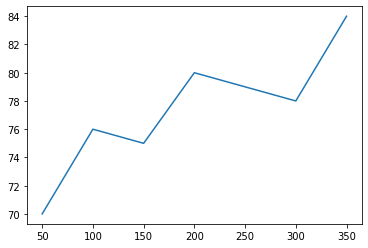

In [10]:
plt.plot(N_i_arr, untrained_accuracy_list)

# Training the model

In [11]:
model_trained = Sequential(
        Conv2d(kernel_size=3),
        ReLU(),
        Conv2d(kernel_size=3, stride=2),
        ReLU(),
        Conv2d(kernel_size=14, padding=0),  # equivalent to a dense layer
        )



In [12]:
model_trained.load_state_dict(torch.load('models/simple_1000_iter.pth'))

<All keys matched successfully>

In [14]:
N_i_arr = np.arange(50, 400, 50)
trained_accuracy_list = []

for ni in tqdm(N_i_arr):
    Y_pred_trained = KernelFlowsCNNGP.kernel_regression(X_test=X_test, X_train = X_train[:ni], Y_train = Y_train[:ni].to(torch.float32), kernel = model_trained)
    Y_pred_trained = torch.argmax(Y_pred_trained, axis=1)
    trained_accuracy_list.append(get_accuracy(Y_pred_trained.detach().numpy(), Y_test.detach().numpy()))

100%|██████████| 7/7 [00:52<00:00,  7.53s/it]


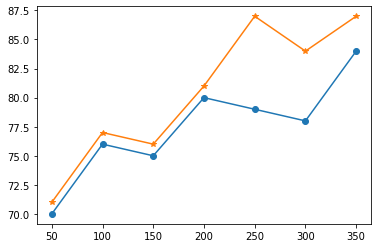

In [15]:
plt.plot(N_i_arr, untrained_accuracy_list, '-o')
plt.plot(N_i_arr, trained_accuracy_list, '-*')